# Machine Learning Course Project
## Identifying User Stance On Social Media via Semi-Supervised Learning

### Overview

#### Midsem Pipeline - 

 - **Read Data**: Read text files to load all the words. 
 - **Clean Data**: Remove stop-words, everything lowercase, dehashify hashtags.
 - **Format Data**: Create data in a format required by each baseline method. 
 - **Baseline Approaches**: LSA, pLSA, Para2Vec, LDA Topic Modelling. The goal of these approaches is to create a "FIXED SIZE" and "HIGH LEVEL" feature representation for variable length tweets. These representations leverage our unlabelled data. 
 - **Training**: Some Supervised Learning on the learned representation using the given labels. 
 - **Evaluation**: Compare the different methods mentioned above on different datasets. 

#### Endsem Approaches - 
 - LDA2Vec - https://www.datacamp.com/community/tutorials/lda2vec-topic-model
 - Gaussian LDA - https://rajarshd.github.io/papers/acl2015.pdf
 - Word Embeddings Informed Topic Models - http://proceedings.mlr.press/v77/zhao17a/zhao17a.pdf
 
#### Reference
 - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Constants

In [1]:
# PATH_LABELLED_DATA_TRAINING = "../semeval2016-task6-domaincorpus/data-all-annotations/trainingdata-all-annotations.txt"
PATH_LABELLED_DATA_TRUMP = "../semeval2016-task6-domaincorpus/data-all-annotations/testdata-taskB-all-annotations.txt"
PATH_UNLABELLED_DATA_TRUMP = "./../semeval2016-task6-domaincorpus/downloaded_Donald_Trump.txt"

## Data 

In [2]:
# SETUP
# # Run in python console
# import nltk; nltk.download('stopwords')

# # Run in terminal or command prompt
# !python -m spacy download en

In [3]:
# !pip install gensim
# !pip install pyLDAvis

In [4]:
import pandas as pd
import numpy as np
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LsiModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['via'])

### Read Sem-Eval Task A Data (Labelled)

Interactive Visualization - http://www.saifmohammad.com/WebPages/StanceDataset.htm

Targets - 
 - Hilary Clinton
 - Atheism
 - Climate Change
 - Donald Trump
 - Feminism
 - Abortion

### Remove Symbols

In [6]:
def clean_tweets(sent):
    sent = str(sent)
    
    # Remove new line characters
    sent = re.sub('\s+', ' ', sent)

    # Remove distracting single quotes
    sent = re.sub("\'", "", sent)

    # Remove distracting single quotes
    sent = re.sub("\"", "", sent)

    # Remove hashtags
    sent = re.sub("\#", "", sent)

    # Remove http:// links
    sent = re.sub('http:\/\/.*','', sent)

    # Remove https:// links
    sent = re.sub('https:\/\/.*','', sent)
    
    # Remove emojis
#     emoji_pattern = re.compile("["
#         u"\U0001F600-\U0001F64F"  # emoticons
#         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#         u"\U0001F680-\U0001F6FF"  # transport & map symbols
#         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            "]+", flags=re.UNICODE)
    
#     sent = emoji_pattern.sub(r'', sent)
    
    return sent
    

In [7]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

data_X = pd.concat([X_train, X_test], ignore_index=True, axis=0)
data_y = pd.concat([y_train, y_test], ignore_index=True, axis=0)
data_labelled = pd.concat([data_X, data_y], ignore_index=True, axis=1)
data_labelled.columns = ['Tweet', 'Stance']
# data_labelled = pd.DataFrame([data_labelled], columns = ['Tweet', 'Stance'])
# data_labelled = data_labelled.where(data_labelled.Target != np.nan)

#### Data Stats

In [8]:
data_labelled.where(data_labelled.Stance == 'AGAINST').count()

Tweet     299
Stance    299
dtype: int64

In [9]:
data_labelled.where(data_labelled.Stance == 'NONE').count()

Tweet     299
Stance    299
dtype: int64

In [10]:
data_labelled.where(data_labelled.Stance == 'FAVOR').count()

Tweet     299
Stance    299
dtype: int64

### Read Sem-Eval Task B Data (Unlabelled)

In [11]:
data_unlabelled = pd.read_csv(PATH_UNLABELLED_DATA_TRUMP, sep='\t', lineterminator='\n', encoding ='latin1', names = ["ID", "Tweet"])
data_unlabelled = data_unlabelled.where(data_unlabelled.Tweet != 'Not Available')
data_unlabelled.dropna(how='any', inplace=True)
data_unlabelled['Tweet'] = data_unlabelled['Tweet'].apply(lambda x: x[1:])
data_unlabelled['Tweet'] = data_unlabelled['Tweet'].apply(clean_tweets)
# data_unlabelled = data_unlabelled[:1000]
# data_unlabelled['Tweet'] = data_unlabelled['Tweet'].str.decode('latin1')

In [12]:
combined_data = pd.concat([data_labelled], ignore_index=True)

In [13]:
combined_data.count()

Tweet     897
Stance    897
dtype: int64

In [14]:
combined_data.head(10)

,Tweet,Stance
0,Today & everyday I am proud to be an American....,AGAINST
1,@JonathanHoenig Why arent Americans allowed WE...,NONE
2,@toddstarnes Marriage is designed and defined ...,NONE
3,@realDonaldTrump we need someone like you who ...,FAVOR
4,@Dahat8 @Stonewall_77 The HATE within America ...,AGAINST
5,@Rene_gadeCowboy @danoroadblade yes but if a c...,NONE
6,@FFRNNU Maybe MSM should be talking more about...,AGAINST
7,@realDonaldTrump had a point and one the liber...,FAVOR
8,Did anyone cut ties with Senator Lindsey Graha...,AGAINST
9,"@GOP If you can not debate Trump, you should n...",FAVOR


In [15]:
df = combined_data['Tweet']
# df = data_labelled['Tweet']

In [16]:
data = df.values.tolist()
pprint(data[:1])

['Today & everyday I am proud to be an American. Im honored to be apart of the '
 'best the world has to offer! 4thofJuly SemST']


### Sentences To Words

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['today',
  'everyday',
  'am',
  'proud',
  'to',
  'be',
  'an',
  'american',
  'im',
  'honored',
  'to',
  'be',
  'apart',
  'of',
  'the',
  'best',
  'the',
  'world',
  'has',
  'to',
  'offer',
  'thofjuly',
  'semst']]


### Create Bi-Grams Tri-Grams

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['today', 'everyday', 'am', 'proud', 'to', 'be', 'an', 'american', 'im', 'honored', 'to', 'be', 'apart', 'of', 'the', 'best', 'the', 'world', 'has', 'to', 'offer', 'thofjuly', 'semst']


### Remove Stop Words and Lemmatize

WE NEED PRONOUNS FOR STANCE

In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PRON']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PRON'])

print(data_lemmatized[:1]), print(len(data_lemmatized))

[['today', 'everyday', 'proud', '-PRON-', 'be', 'honor', 'apart', 'good', 'world', 'offer', 'thofjuly', 'semst']]
897


(None, None)

## Format Data

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


In [22]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('-PRON-', 1),
  ('apart', 1),
  ('be', 1),
  ('everyday', 1),
  ('good', 1),
  ('honor', 1),
  ('offer', 1),
  ('proud', 1),
  ('semst', 1),
  ('thofjuly', 1),
  ('today', 1),
  ('world', 1)]]

In [23]:
len(id2word)

1826

## LDA

### Model 2

In [24]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet('./mallet-2.0.8/bin/mallet', corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

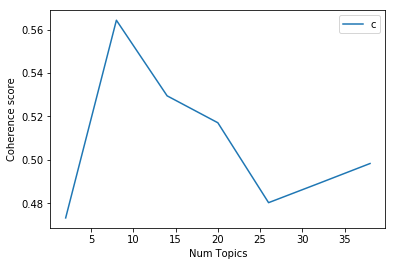

In [27]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
len(corpus)

897

In [29]:
num_topics = x[np.argmax(coherence_values)]

In [30]:
num_topics

8

In [31]:
mallet_path = './mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
ldamallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [32]:
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("lda-mallet-model-only-labelled-without-unlabelled-"+str(num_topics))
ldamallet.save(temp_file)

In [33]:
from gensim.test.utils import datapath

temp_file = datapath("lda-mallet-model-only-labelled-without-unlabelled-"+str(num_topics))
# Load a potentially pretrained model from disk.
ldamallet = gensim.models.ldamodel.LdaModel.load(temp_file)

In [34]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('-PRON-', 0.15141955835962145),
   ('america', 0.0694006309148265),
   ('semst', 0.058885383806519455),
   ('president', 0.03785488958990536),
   ('truth', 0.03680336487907466),
   ('nbc', 0.028391167192429023),
   ('macy', 0.028391167192429023),
   ('love', 0.016824395373291272),
   ('put', 0.014721345951629864),
   ('fuck', 0.013669821240799159)]),
 (1,
  [('trump', 0.2321618743343983),
   ('donald', 0.027689030883919063),
   ('medium', 0.021299254526091587),
   ('mexican', 0.02023429179978701),
   ('call', 0.019169329073482427),
   ('hillary', 0.014909478168264111),
   ('fire', 0.013844515441959531),
   ('ppl', 0.010649627263045794),
   ('immigrant', 0.010649627263045794),
   ('dem', 0.010649627263045794)]),
 (2,
  [('semst', 0.20600414078674947),
   ('run', 0.031055900621118012),
   ('american', 0.025879917184265012),
   ('stop', 0.019668737060041408),
   ('true', 0.018633540372670808),
   ('move', 0.015527950310559006),
   ('ericboll', 0.013457556935817806),
   ('work', 0

### Topic Quality Inspection

#### Model 2

In [35]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5767772164143474


## Evaluation

### Format Labelled Data

In [37]:
labelled_corpus = corpus
len(labelled_corpus)

897

### Create Dataset for Supervised Learning

In [38]:
mallet_feats = []

for i in range(len(labelled_corpus)):
    representation = ldamallet.get_document_topics(labelled_corpus[i])
    count = 0
    feat = []
    for i in range(num_topics):
        if i in list(map((lambda x: x[0]), representation)):
            feat.append(representation[count][1])
            count = count + 1
        else:
            feat.append(0)
    mallet_feats.append(feat)

In [39]:
STANCES = ['AGAINST', 'FAVOR', 'NONE']

In [40]:
def transform_labels(label):
    if label == 'AGAINST':
        return 0
    elif label == 'FAVOR':
        return 1
    elif label == 'NONE':
        return 2

In [41]:
# labelled_stance = combined_data.Stance[53616:54323]
labelled_stance = data_labelled['Stance']
labelled_stance = labelled_stance.apply(transform_labels)
labelled_stance = labelled_stance.tolist()

In [42]:
len(mallet_feats[0]), len(mallet_feats)

(8, 897)

## Supervised Learning

In [43]:
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import argparse
from sklearn.utils.multiclass import unique_labels

In [44]:
## Create Train Test Split
X_train = mallet_feats[:627]
X_test = mallet_feats[627:]
y_train = labelled_stance[:627]
y_test = labelled_stance[627:]

In [45]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [46]:
def RandomForest(X_train, X_test, y_train, y_test):
    
    # GRID SEARCH
    parameters = {'n_estimators':range(100,600,100), 'max_depth':range(1,20,5)}
    rlf = RandomForestClassifier(random_state=0)
    rlf = GridSearchCV(rlf, parameters, cv=5)
    rlf.fit(X_train, y_train)
    
    y_pred = rlf.predict(X_test)

    rf_cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, classes=STANCES,
                      title='Confusion matrix, without normalization')

    rf_cv = cross_val_score(rlf, X_train, y_train, cv=5, scoring='f1_macro')
    report = {}
    report["RF_cross_val_score"] = rf_cv.tolist()
    report["RF_mean_acc"] = rf_cv.mean()
    report["RF_std_acc"] = rf_cv.std()*2
    report["RF_params"] = rlf.cv_results_
    
    report["RF_CM"] = rf_cm.tolist()

    
    return report

In [47]:
def SVMClassifier(X_train, X_test, y_train, y_test):

    parameters = {'kernel':['linear','rbf','poly'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    
    clf = svm.SVC(gamma='auto')
    clf = GridSearchCV(clf, parameters, cv=5)
    clf.fit(X_train, y_train)
    
    clf_cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
    report = {}
    report["SVM_cross_val_score"] = clf_cv.tolist()
    report["SVM_mean_acc"] = clf_cv.mean()
    report["SVM_std_acc"] = clf_cv.std()*2
    report["SVM_params"] = clf.cv_results_

    
    y_pred = clf.predict(X_test)

    clf_cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, classes=STANCES,
                      title='Confusion matrix, without normalization')

    report["SVM_CM"] = clf_cm.tolist()

    
    return report
    

Confusion matrix, without normalization
[[70  9  9]
 [ 8 77  7]
 [11  5 74]]
{'RF_cross_val_score': [0.7734726971720134, 0.692493175251796, 0.7491078835518975, 0.7476497621075935, 0.6712962962962964], 'RF_mean_acc': 0.7268039628759193, 'RF_std_acc': 0.07677663280154609, 'RF_params': {'mean_fit_time': array([0.12294698, 0.22755122, 0.32817659, 0.43811522, 0.54915686,
       0.136939  , 0.26830378, 0.40463138, 0.53876138, 0.67788424,
       0.14768114, 0.296661  , 0.44385738, 0.59445982, 0.74188838,
       0.15225611, 0.29720464, 0.4487617 , 0.59791508, 0.78116422]), 'std_fit_time': array([0.01299752, 0.01220333, 0.0063497 , 0.00327672, 0.0037245 ,
       0.00337366, 0.00330474, 0.00465161, 0.006302  , 0.00406907,
       0.00199562, 0.00415537, 0.00618894, 0.00813033, 0.01154636,
       0.00281214, 0.00380051, 0.00727146, 0.00968724, 0.02557677]), 'mean_score_time': array([0.00702701, 0.01288075, 0.01925516, 0.02550864, 0.0311904 ,
       0.00752439, 0.01394448, 0.02036572, 0.02718582, 0

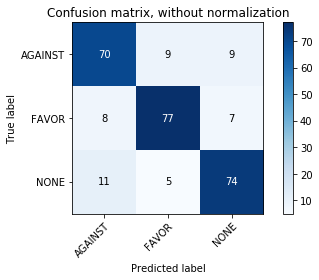

In [48]:
mallet_report = RandomForest(X_train, X_test, y_train, y_test)
print(mallet_report)

Confusion matrix, without normalization
[[29 31 28]
 [29 52 11]
 [28 22 40]]
{'SVM_cross_val_score': [0.5010400682011935, 0.47423215898825655, 0.38567582604279854, 0.4779155285328178, 0.4504915245230883], 'SVM_mean_acc': 0.45787102125763096, 'SVM_std_acc': 0.07899184209992276, 'SVM_params': {'mean_fit_time': array([0.00701637, 0.01052995, 0.00675464, 0.00678873, 0.01054211,
       0.00717821, 0.00649753, 0.00999646, 0.00653586, 0.00651717,
       0.01014581, 0.00686002, 0.00649614, 0.01015482, 0.00717859,
       0.00677595, 0.00982342, 0.00872002, 0.00961881, 0.01033044,
       0.00705128]), 'std_fit_time': array([0.00092068, 0.00171878, 0.00018889, 0.00076075, 0.00124957,
       0.00084061, 0.00058515, 0.0005832 , 0.00026809, 0.00040825,
       0.00060133, 0.00014155, 0.00018468, 0.00036668, 0.00037172,
       0.00030231, 0.00028509, 0.00089587, 0.00053023, 0.00025237,
       0.00039601]), 'mean_score_time': array([0.00116096, 0.00191498, 0.00115318, 0.00135212, 0.001895  ,
       0.0

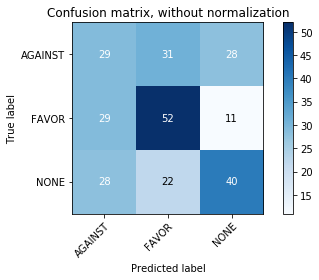

In [49]:
mallet_report = SVMClassifier(X_train, X_test, y_train, y_test)
print(mallet_report)